In [1]:
# Everything same as christmas model: onroad, clsutering + yaw, 
# but dbscan replaced with radius threshold to all, plus road standardization

1. prepare the agent table first:
   * remove off-road, 
   * add hostcar, 
   * remove big cars,
   * enhance yaw by (19.8/2pi)
   
   * sampling optional
2. For each frame in scene 0,
   * cluster up each agent and their neighboring agents with a fixed radius threshold 20
     by x, y, yaw
   * each frame gets a list of clusters; clusters have no class objects for their own.
   * remove cluster if agent close to a crosswalk polygon
3. for each frame_clusters:
   * in increments of 3
   * for each cluster in the first frame cluster of the sequence (see note3)
   * if their anchor track_id is still present in all other frame clusters in the sequence:
   * if absent, drop them - round 1 of cluster filtering - 
   * if present, check if set_uniformity is above 0.5, if not, remove,
   * return remaining cluster_sequences
4. pivot, standardize
   * pivot by x, y, YAW
   * road_standardize x, y, yaw point at 0pi; remember to modulus the new YAW!
   * cap and zeropad 20 track_ids
6. partitions:
   * increments of 4: 3 inputs, 1 output

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

folderpath = "*"
folderpath = "C:\\Users\\Benson\\Desktop"
file = folderpath + "\\lyftlong\\rand_agents_table0_scene_3kind_onroadDiscrete.csv"
at_orig = pd.read_csv(file)
file = folderpath + "\\lyftlong\\rand_frames_table1.csv"
ft_orig = pd.read_csv(file)
file = folderpath +  "\\lyftlong\\rand_scenes_table1.csv"
st_orig = pd.read_csv(file)

In [3]:
at = at_orig.copy()
ft = ft_orig.copy()
st = st_orig.copy()

In [4]:
def set_intersection(list_of_sets):
    """
    Gets the intersection of multiple sets
    """
    len_list_of_sets = len(list_of_sets)
    if len_list_of_sets == 0:
        # only activates when the original list of sets is literally empty
        return set([])
    if len_list_of_sets == 1:
        # recursion's base case
        return list_of_sets[0]
    middle = math.floor(len_list_of_sets / 2)
    return set_intersection(list_of_sets[:middle]) | set_intersection(list_of_sets[middle:])
def set_union(list_of_sets):
    """
    Gets the union of multiple sets
    """
    len_list_of_sets = len(list_of_sets)
    if len_list_of_sets == 0:
        # only activates when the original list of sets is literally empty
        return set([])
    if len_list_of_sets == 1:
        # recursion's base case
        return list_of_sets[0]
    middle = math.floor(len_list_of_sets / 2)
    return set_union(list_of_sets[:middle]) | set_union(list_of_sets[middle:])

def set_uniformity(sets_list):
    overlap = set_intersection(sets_list)
    union = set_union(sets_list)
    if union == 0:
        return False
    else:
        if (len(overlap)/len(union)) < 0.5:
            return False
        else:
            return True

In [5]:
def agents0_prepare_agent_table(agents_table):
    agents_table = agents0d_filter_oversized_track_ids(agents_table)
    agents_table = agents0c_reduce_columns(agents_table)
    agents_table = agents0b_enhance_yaws(agents_table, 20)
    agents_table = agents0a_filter_onroad(agents_table)
    return agents_table
    
def agents0c_reduce_columns(agents_table):
    agents_table_columns = [
        'centroid_x', 'centroid_y', 'yaw', 'kind', 
        'on_road', 'track_id','frame_index', 'scene_index']
    agents_table = agents_table[agents_table_columns]
    return agents_table

def agents0a_filter_onroad(agents_table: pd.DataFrame) -> pd.DataFrame:
    agents_table_onroad = agents_table[agents_table.on_road == 1]
    return agents_table_onroad

# FEATURE: overbig
def agents0d_filter_oversized_track_ids(agents_table: pd.DataFrame) -> pd.DataFrame:
    # removed big objects
    MAX_LENGTH_VEHICLES = 19.8 # federally mandated maximum length of vehicles
    # any cars in the dataset that has a sidelength greater than this was probably a data-mistake
    
    temp_mean_at = agents_table.groupby(['scene_index','track_id'], as_index = False).mean()
    overbig_track_ids = temp_mean_at[(temp_mean_at.extent_x > MAX_LENGTH_VEHICLES) |
                                     (temp_mean_at.extent_y > MAX_LENGTH_VEHICLES)]
    overbig_track_ids = overbig_track_ids[["scene_index", "track_id"]]
    merged = pd.merge(agents_table,overbig_track_ids, how='outer', on=["scene_index", "track_id"], indicator=True)
    left_anti_merge = merged[merged['_merge'] == 'left_only']#.drop(columns=["_merged"])
    left_anti_merge = left_anti_merge.drop(columns=["_merge"])
    return left_anti_merge
    
    

def agents0b_enhance_yaws(agents_table: pd.DataFrame, 
                          yaw_enhancer: float = 20/(2*np.pi)) -> pd.DataFrame:
    agents_table['yaw'] *= yaw_enhancer
    return agents_table

In [6]:
class Time_Series_Partition:
    def __init__(self,
                 input_array: np.ndarray,
                 output_row: np.ndarray):
        self.input_array = input_array
        self.output_row = output_row

In [7]:
class Cluster:
    """
    Class object to represent 1 cluster of entities in a frame
    """
    def __init__(self, 
                 scene_index: int,
                 frame_index: int,
                 anchor: int,
                 cluster: set([int]),
                ):
        self.scene_index = scene_index
        self.frame_index = frame_index
        self.anchor = anchor # dbscan cluster label OR anchor track_id
        self.cluster = cluster # set of track_ids
        # use global frame_index
    def __repr__(self):
        return "{0}: {1}".format(str(self.anchor), str(self.cluster))

In [8]:
class Clusters_Sequence:
    """
    Sequential Container Class object to a cluster's transformation in time;
    it is basically a list of clusters with the same anchor attribute
    """
    def __init__(self, 
                 clusters: [Cluster],
                ):
        self.cluster_sequence = clusters
        self.rank = len(clusters)
        self.anchor = clusters[0].anchor
    def __repr__(self):
        return "".join([repr(cluster)+"\n" for cluster in self.cluster_sequence])

In [9]:
class Frame_Clusters:
    """
    Container Class object that holds a list of all clusters with the same frame_index attribute
    """
    def __init__(self, 
                 scene_index: int,
                 frame_index: int,
                 clusters_dict: dict,
                ):
        self.scene_index = scene_index
        self.frame_index = frame_index 
        self.frame_clusters = clusters_dict.values()
        # assert all(cluster.frame_index == self.frame_index for cluster in self.frame_clusters)
        self.clusters_dict = clusters_dict 
    def __getitem__(self, key):
        return self.clusters_dict[key]
    def __repr__(self):
        return "".join([repr(cluster)+"\n" for cluster in self.frame_clusters])

In [10]:
def agents1b_get_scene_index_by_scene_list_index(scene_table: pd.DataFrame, 
                                                 scene_list_index: int) -> int:
    assert scene_list_index >= 0 and scene_list_index <= 100 
    scene_index = st.scene_index.values[scene_list_index]
    return scene_index

In [11]:
from shapely.geometry import Point, Polygon 

folderpath = "C:\\Users\\Benson\\Desktop\\"
cw_df_orig = pd.read_csv(folderpath + "lyftlong\\crosswalks_table0.csv")
cw_df = cw_df_orig.copy()
cw_df["pairs"] = list(np.dstack((cw_df.cw_coord_x.values, cw_df.cw_coord_y.values))[0] )
polygon_vertices_list = cw_df.groupby('cw_id')["pairs"].apply(list)

crosswalk_polygon_list = [Polygon(polygon_vertices) for polygon_vertices in polygon_vertices_list]

In [42]:
def radius_classification(anchor_track_id: int, 
                          anchor_agents_table: pd.DataFrame,
                          max_radius: int = 20) -> [int]:
    # get anchor agent's values
    anchor_row = anchor_agents_table[anchor_agents_table.track_id == anchor_track_id]
    anchor_scene_index  = anchor_row["scene_index"].values[0]
    anchor_frame_index  = anchor_row["frame_index"].values[0]    
    anchor_x   = anchor_row["centroid_x"].values[0]
    anchor_y   = anchor_row["centroid_y"].values[0]
    anchor_yaw = anchor_row["yaw"       ].values[0]
    # get differences of every other agent in the frame (anchor_agents_table) in terms of values above
    
    x_diff   = (anchor_agents_table["centroid_x"].values - anchor_x)**2
    y_diff   = (anchor_agents_table["centroid_y"].values - anchor_y)**2
    yaw_diff = (anchor_agents_table["yaw"].values - anchor_yaw)**2
    
    anchor_dist = np.sqrt(x_diff + y_diff + yaw_diff)
    anchor_agents_table["anchor_dist"] = anchor_dist
    
    anchor_agents_table = anchor_agents_table[anchor_agents_table.anchor_dist < max_radius]
    
    cluster = Cluster(
                      scene_index = anchor_scene_index,
                      frame_index = anchor_frame_index,
                      anchor = anchor_track_id,
                      cluster = set(anchor_agents_table["track_id"].values))
    return cluster

def intersection_proximity(anchor_track_id, anchor_agents_table, max_radius = 20):
    global crosswalk_polygon_list
    anchor_row = anchor_agents_table[anchor_agents_table.track_id == anchor_track_id]   
    anchor_x   = anchor_row["centroid_x"].values[0]
    anchor_y   = anchor_row["centroid_y"].values[0]
    point = Point(anchor_x, anchor_y)
    return any([(poly.distance(point) < max_radius) for poly in crosswalk_polygon_list])

def iterate_radius_classification(frame_onroad_agents_table):
    # one frame
    unique_track_ids = pd.unique(frame_onroad_agents_table["track_id"])
    radius_cluster_dict = dict()
    for unique_track_id in (unique_track_ids):
        
        if intersection_proximity(unique_track_id, frame_onroad_agents_table): continue
        cluster = radius_classification(unique_track_id, frame_onroad_agents_table)
        
        radius_cluster_dict[unique_track_id] = cluster
    return radius_cluster_dict

def cluster_creation_after_full_agents_table_selection(agents_table_selected: pd.DataFrame) -> dict:
    """
    agents_table_selected is the agent table of 1 frame in 1 scene.
    """
    # reduced the table to speed up next line.
    cluster_trackid_dict = iterate_radius_classification(agents_table_selected)
    return cluster_trackid_dict


In [27]:
def get_scene_i_frame_clusters_list(agents_table, 
                                    scene_index: int,
                                    frame_index_start,
                                    scene_frames_amount) -> [Frame_Clusters]:
    global scenes_table, frames_table
    scene_i_frame_clusters_list = []
    
    frame_length = scene_frames_amount

    frame_length_starter = 0
    
    frame_length = int(scene_frames_amount * 0.25)
    frame_length_starter = np.random.randint(0, frame_length - 3)

    for frame_list_index in range(frame_length_starter, frame_length_starter + frame_length):
        
        frame_index = frame_index_start + frame_list_index
        
        agents_table_frame_selection = agents_table[agents_table.frame_index == frame_index]    
        
        clusters_dict = cluster_creation_after_full_agents_table_selection(agents_table_frame_selection)

        frame_clusters = Frame_Clusters(
                                        frame_index = frame_index,
                                        scene_index = scene_index,
                                        clusters_dict = clusters_dict)

        scene_i_frame_clusters_list.append(frame_clusters)
    return scene_i_frame_clusters_list

In [28]:
agents_table = agents0_prepare_agent_table(at_orig.copy())
scenes_table = st_orig.copy()
frames_table = ft_orig.copy()

In [29]:
def clustering_set_operations(scene_k_frames_clusters_list: [Frame_Clusters]):
    def verify_anchor_in_all_frame_clusters(anchor, scene_k_frames_clusters_list):
        return all([(anchor in frame_cluster.clusters_dict.keys()) 
                    for frame_cluster in scene_k_frames_clusters_list])
    first_frame_clusters = scene_k_frames_clusters_list[0]
    
    anchors = first_frame_clusters.clusters_dict.keys()
    final_cluster_sequences = []
    for anchor in anchors:
        if verify_anchor_in_all_frame_clusters(anchor, scene_k_frames_clusters_list) == True:
            anchor_sequence_sets = []
            cluster_sequences = []
            for frame_cluster in scene_k_frames_clusters_list:
                cluster_sequences.append(frame_cluster[anchor])
                anchor_sequence_sets.append(frame_cluster[anchor].cluster)
            if set_uniformity(anchor_sequence_sets):
                cluster_sequence = Clusters_Sequence(cluster_sequences)
                final_cluster_sequences.append(cluster_sequence)
    return final_cluster_sequences

In [30]:
def create_scene_i_frame_cluster_sequences(sequence_length, scene_i_frame_clusters_list):
    scene_i_frame_cluster_sequences = []

    k = sequence_length
    
    for i in range(k - 1, len(scene_i_frame_clusters_list)):
        
        scene_k_frames_clusters_list = scene_i_frame_clusters_list[i-(k-1):i+1] # 3 frame_clusters
        
        final_cluster_sequences = clustering_set_operations(scene_k_frames_clusters_list)
        
        scene_i_frame_cluster_sequences.extend(final_cluster_sequences)
    return scene_i_frame_cluster_sequences

In [31]:
K = 3
def array_track_id_standardization(agents_array: np.ndarray):
    
    place_holder = 0
    
    MAX_TRACK_IDS = 20
    
    FEATURES_AMOUNT = 3
    
    num_track_ids = agents_array.shape[1] // FEATURES_AMOUNT
    track_ids_disparity = MAX_TRACK_IDS - num_track_ids
        
    if track_ids_disparity < 0:
        # oversized
        agents_array_standardized = agents_array[:,:MAX_TRACK_IDS * FEATURES_AMOUNT]
    else:
        dummy_array = np.full((K, track_ids_disparity*FEATURES_AMOUNT), place_holder)
        try:
            agents_array_standardized = np.column_stack((agents_array, dummy_array))
        except:
            print(agents_array.shape, dummy_array.shape)
            assert False
    agents_array_standardized = np.nan_to_num(agents_array_standardized)
    return agents_array_standardized

In [32]:
# ROAD_STANDARDIZATION
import math
def RS1_recenter(agent_table, center_row):
    agent_table["centroid_x"] = agent_table["centroid_x"].values - center_row["centroid_x"].values[0]
    agent_table["centroid_y"] = agent_table["centroid_y"].values - center_row["centroid_y"].values[0]
    return agent_table
def RS2_reyaw2(agent_table, center_row):
    # points center entity's yaw to 0 pi, revolving every object around with it
    # thus changing both their location and yaws
    # Will utilize rotation matrix and matrix multiplication
    YAW_ANCHOR = 0*np.pi
    center_yaw = center_row["yaw"].values[0]
    center_yaw_difference = YAW_ANCHOR - center_yaw
    
    rotation_matrix = np.array([
        [math.cos(center_yaw_difference),-math.sin(center_yaw_difference)],
        [math.sin(center_yaw_difference), math.cos(center_yaw_difference)]
    ])
    
    agent_table_rotation_matrix_input = agent_table[["centroid_x", "centroid_y"]].to_numpy().T
    
    assert agent_table_rotation_matrix_input.shape[0] == 2
    
    agent_table_rotation_matrix_output = rotation_matrix @ agent_table_rotation_matrix_input
    
    # revolve every surrounding agent by center_yaw_difference    
    # reconvert new_thetas and radii for the newly recentered agent table by polar coordinates
    
    agent_table["centroid_x"] = agent_table_rotation_matrix_output[0]
    agent_table["centroid_y"] = agent_table_rotation_matrix_output[1]
    
    agent_table["yaw"] += center_yaw_difference
    agent_table["yaw"] %= 2*math.pi # re-bases them
    
    return agent_table
def road_standardizer(agent_table,
                      cluster_sequences):
    anchor = cluster_sequences.anchor # center track_id
    center_row = agent_table[agent_table.track_id == anchor]
    agent_table = RS1_recenter(agent_table, center_row)
    agent_table = RS2_reyaw2(agent_table, center_row)
    return agent_table

In [33]:

def create_partitions(agent_table,
                      cluster_sequence: Clusters_Sequence):
    
    # step one: get union of all clusters in cluster sequence, set N = length of that 
    track_ids_frame_sets = [cluster.cluster for cluster in cluster_sequence.cluster_sequence]
    # ^ e.g. 
    all_track_ids = list(set_union(track_ids_frame_sets))
    
    frame_index_start = cluster_sequence.cluster_sequence[0].frame_index
    frame_index_end   = cluster_sequence.cluster_sequence[-1].frame_index
    frame_indices = list(range(frame_index_start, frame_index_end + 1))
    k = len(frame_indices)
    
    # step 2: filter agent_table; in terms of track_id, and frame_index
    
    agent_table = agent_table[agent_table.track_id.isin(all_track_ids)]
    agent_table = agent_table[agent_table.frame_index.isin(frame_indices)]
    
    
    # step 2a: road standardizer
    agent_table = road_standardizer(agent_table, cluster_sequence)
    
    # agent_table = agent_table.drop(columns=['yaw'])
    # DO NOT DROP YAW
    
    # step 3: pivot with index= frame_index, column = "track_id"
    pivoted_agent_table = agent_table.pivot(index='frame_index', columns='track_id',)
    
    # step 4: standardize
    # if len(pivoted_agent_table.columns) != 40:
    #    print(pivoted_agent_table.columns)
    pivoted_agent_array = pivoted_agent_table.to_numpy()
    
    
    fixed_agent_array = array_track_id_standardization(pivoted_agent_array)
    k = len(frame_indices)    

    # step 5: break into input, output
    inpt = fixed_agent_array[:k-1]
    outp = fixed_agent_array[k-1]
    
    partition = Time_Series_Partition(
        input_array = inpt,
        output_row  = outp)
    return partition

In [34]:

def create_scene_i_partitions_list(pre_pivoted_agent_table, scene_i_frame_cluster_sequences):
    scene_i_partitions_list = []
    for cluster_sequences in scene_i_frame_cluster_sequences:
        partition = create_partitions(pre_pivoted_agent_table,
                                      cluster_sequences)
        scene_i_partitions_list.append(partition)
    return scene_i_partitions_list

#### EXECUTION STARTS HERE

In [35]:
def add_scene_partitions_dataset(agents_table, scene_list_index):
    global scenes_table, frames_table
    
    # Extracted from A
    scene_index = agents1b_get_scene_index_by_scene_list_index(scene_table = scenes_table,
                                                               scene_list_index = scene_list_index)
    print(scene_index)
    agents_table = agents_table[agents_table.scene_index == scene_index]
    scene_frames_amount = len(pd.unique(agents_table["frame_index"]))
    scene_table_row = scenes_table.iloc[scene_list_index]
    frame_index_start = scene_table_row["frame_index_interval_start"]
    frame_index_end = scene_table_row["frame_index_interval_end"]
    scene_frames_amount = frame_index_end - frame_index_start
    # extracted from A End
    
    
    scene_i_frame_clusters_list = get_scene_i_frame_clusters_list(agents_table, 
                                                                  scene_index,
                                                                  frame_index_start,
                                                                  scene_frames_amount) # A
    ############ A and B cannot be combined ########
    print("clusters in a frame:", len(scene_i_frame_clusters_list))
    k = 3
    
    scene_i_frame_cluster_sequences = create_scene_i_frame_cluster_sequences(k, scene_i_frame_clusters_list) # B
    
    FOR_ROAD_STANDARDIZER = ["yaw"]
    pre_pivoted_agent_table = agents_table[['centroid_x', 'centroid_y', 'track_id', 'frame_index'] + FOR_ROAD_STANDARDIZER]
    
    scene_i_partitions_list  = create_scene_i_partitions_list(pre_pivoted_agent_table,
                                                              scene_i_frame_cluster_sequences) # C
    
    if scene_list_index%10 == 0 and scene_list_index != 0:
        print(scene_i_partitions_list[0].input_array.shape)
        print("Scenes: {0}/{1}".format(str(scene_list_index), str(100)))
    
    return scene_i_partitions_list

In [36]:
def retry(agents_table, scene_list_index):
    try:
        scene_i_partitions_list = add_scene_partitions_dataset(agents_table, scene_list_index)
        return scene_i_partitions_list
    except:
        print("\t retrying scene_list_index {0}".format())
        return retry(agents_table, scene_list_index)

In [37]:
import time
import pickle

scene_partitions_dataset = []

pickle_filename = "radius_threshold_2_partitions_test.pkl"
pickle_file = open(pickle_filename, 'wb')   # Pickle file is newly created where foo1.py is
pickle.dump(scene_partitions_dataset, pickle_file)          # dump data to f
pickle_file.close()

In [38]:
agents_table = agents0_prepare_agent_table(at_orig.copy())
def pickle_partitions(pickle_file_name, 
                      scene_amount = 100):
    global agents_table
    # check first if we left off anywhere
    f = open(pickle_file_name, 'rb')
    stored_data = pickle.load(f)         # load file content as mydict
    f.close()   
    
    current_amount = len(stored_data)
    if current_amount == scene_amount:
        return None
    
    for scene_list_index in range(current_amount, scene_amount):

        start = time.time()
        print("scene_list_index: {0}".format(str(scene_list_index)))
        # add_scene_partitions_dataset(scene_list_index)
        scene_i_partitions_list = retry(agents_table, scene_list_index)
        end = time.time()
        elapsed = end - start
        print(elapsed)
        
        
        
        scene_partitions_dataset.append(scene_i_partitions_list)
        
        if (scene_list_index + 1)%5 == 0:
            print("DO NOT HALT; OVERWRITING FILE; PLEASE WAIT")        
            f = open(pickle_file_name, 'rb')   # 'r' for reading; can be omitted
            stored_data = pickle.load(f) 
            stored_data = scene_partitions_dataset
            
            f = open(pickle_file_name, "wb")
            pickle.dump(stored_data, f)          # dump data to f
            f.close()
            
            print("OVERWRITING FILE DONE; YOU MAY NOW HALT")
    

In [43]:
pickle_partitions(pickle_filename, scene_amount = 50)

scene_list_index: 0
7827


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


clusters in a frame: 62
11.031585454940796
scene_list_index: 1
15982
clusters in a frame: 62
16.090540647506714
scene_list_index: 2
10378
clusters in a frame: 62
10.59829044342041
scene_list_index: 3
154
clusters in a frame: 62
10.62233567237854
scene_list_index: 4
9380
clusters in a frame: 62
8.827515363693237
DO NOT HALT; OVERWRITING FILE; PLEASE WAIT
OVERWRITING FILE DONE; YOU MAY NOW HALT
scene_list_index: 5
15002
clusters in a frame: 62
6.358933687210083
scene_list_index: 6
4455


IndexError: tuple index out of range

## Partitions created; Now onto Time Series Forecasting

In [54]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout

Using TensorFlow backend.
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [44]:
f = open(pickle_filename, 'rb')   # 'r' for reading; can be omitted
stored_data_final = pickle.load(f)         # load file content as mydict
f.close()   
len(stored_data_final)

5

len(stored_data_final[0]) #[0]

In [46]:
scene_partitions_dataset_unwrapped = [i for x in stored_data_final for i in x]
len(scene_partitions_dataset_unwrapped)

2462

In [48]:
for i in range(len(scene_partitions_dataset_unwrapped)):
    if ((scene_partitions_dataset_unwrapped[i].input_array).shape) != (2,60):
        print(i, ((scene_partitions_dataset_unwrapped[i].input_array).shape))

In [49]:
TRAIN_PROPORTION = 0.8
TRAIN_PROPORTION_INDEXER = int(len(scene_partitions_dataset_unwrapped) * 0.8)

np.random.shuffle(scene_partitions_dataset_unwrapped)

X_train = []
y_train = []
X_test = []
y_test = []
for i in range(len(scene_partitions_dataset_unwrapped)): # [:TRAIN_PROPORTION_INDEXER]:
    partition = scene_partitions_dataset_unwrapped[i]
    if i <= TRAIN_PROPORTION_INDEXER:
        X_train.append(partition.input_array)
        y_train.append(partition.output_row)
    else:
        X_test.append(partition.input_array)
        y_test.append(partition.output_row)        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [50]:
X_train.shape

(1970, 2, 60)

In [51]:
assert not np.isnan(X_train).any()
assert not np.isnan(y_train).any()
assert not np.isnan(X_test).any()
assert not np.isnan(y_test).any()

In [52]:
assert not np.isinf(X_train).any()
assert not np.isinf(y_train).any()
assert not np.isinf(X_test).any()
assert not np.isinf(y_test).any()

In [114]:
n_steps = 2
n_features = (60)

act = None
retseq = True

LOSS_FUNCTION = "mse" # loss=tf.keras.losses.cosine_similarity

#### define model
model = Sequential()
model.add(LSTM(100, activation=act, return_sequences=retseq, input_shape=(n_steps, n_features)))
# model.add(Dropout(0.2))
model.add(LSTM(50, activation=act)) #, return_sequences=retseq,))

model.add(Dense(n_features))
model.compile(optimizer='adam', loss=LOSS_FUNCTION)
# model.compile(loss='cosine_proximity', optimizer='sgd')


In [115]:
history = model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
1970/1970 [==============================] - 2s 1ms/sample - loss: 8.5214
Epoch 2/10
1970/1970 [==============================] - 0s 209us/sample - loss: 4.4689
Epoch 3/10
1970/1970 [==============================] - 0s 207us/sample - loss: 2.9152
Epoch 4/10
1970/1970 [==============================] - 0s 205us/sample - loss: 2.1248
Epoch 5/10
1970/1970 [==============================] - 0s 205us/sample - loss: 1.6704
Epoch 6/10
1970/1970 [==============================] - 0s 203us/sample - loss: 1.4074
Epoch 7/10
1970/1970 [==============================] - 0s 202us/sample - loss: 1.2283
Epoch 8/10
1970/1970 [==============================] - 0s 198us/sample - loss: 1.1044
Epoch 9/10
1970/1970 [==============================] - 0s 197us/sample - loss: 1.0074
Epoch 10/10
1970/1970 [==============================] - 0s 198us/sample - loss: 0.9343


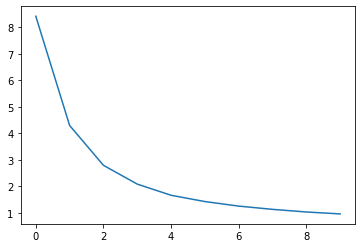

In [57]:
plt.plot(history.history["loss"])

In [58]:
len(y_test)

492

380
0.8494707224139085


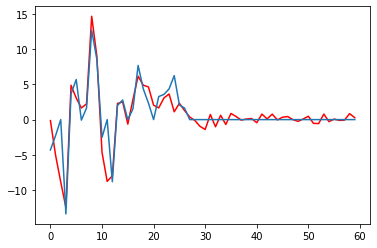

In [86]:
from scipy import spatial

i = np.random.choice(list(range(len(y_test))))
print(i)

x1pred = model.predict(X_test)[i]
y1targ = y_test[i]
cosine_similarity = 1 - spatial.distance.cosine(x1pred, y1targ)
print(cosine_similarity)

plt.plot(x1pred, c="red")

plt.plot(y1targ)

In [69]:
import random
total_success = 0
len_test = len(y_test)

rand_indices = np.arange(len_test)
np.random.shuffle(rand_indices)

for i in range(len_test):
    if i % 50 == 0:
        print("\t {0}/{1}: {2}".format(i, len_test, total_success/(i + 1)))
    ri = rand_indices[i]
    x1pred = model.predict(X_test)[ri]
    y1targ = y_test[ri]
    cosine_similarity = 1 - spatial.distance.cosine(x1pred, y1targ)
    success = cosine_similarity * 100
    total_success += success

	 0/492: 0.0
	 50/492: 86.49339863831071
	 100/492: 88.76544977039512
	 150/492: 89.45709332085853
	 200/492: 89.76242792457897
	 250/492: 89.9984526777982
	 300/492: 89.37264291564792
	 350/492: 89.39112789695524
	 400/492: 89.36441972161441
	 450/492: 89.97539440696768


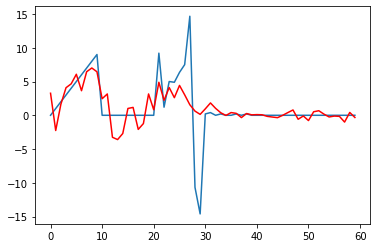

In [209]:
import random
yz = 10
nz = 20 - yz
x0 = list(range(10)) + list([0 for _ in range(nz)])
y0 = [0] + list(np.random.randint(-10, 10, yz - 1)) + list([0 for _ in range(nz)])
a0 = [0*np.pi for _ in range(20)]

def rnd(i):
    speedup = random.choice([1, 0])
    if speedup == 0:
        output = i * 1 + 0+ random.choice([1, 0])*0.2
    else:
        speedup_factor = random.choice((np.linspace(1,1.5,10)))
        
        output = i * speedup_factor
    return output

def new_row(y0):
    y1 = [0] + [rnd(i) for i in y0[1:]]
    return y1


r0 = x0 + y0 + a0
y1 = new_row(y0)
y2 = new_row(y1)
y3 = new_row(y2)
r1 = x0 + y1 + a0
r2 = x0 + y2 + a0
r3 = x0 + y3 + a0


rx  =  np.array([[r0, r1]])
rxy = model.predict(rx)[0]

plt.plot(r2)

plt.plot(rxy, c="red")

plt.plot(r0)

plt.plot(r3, c="red")

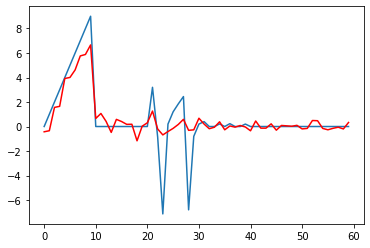

In [204]:
rx  =  np.array([[r0, r1]])
rxy = model.predict(rx)[0]

plt.plot(r2)

plt.plot(rxy, c="red")

In [123]:
1 - spatial.distance.cosine(rxy, r2)

0.7405460255188341

0.6864897735226608

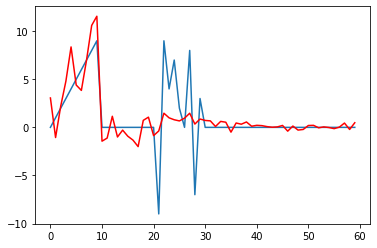

In [124]:
rx2  =  np.array([[r1, rxy]])
rx2y = model.predict(rx2)[0]
plt.plot(r3)
plt.plot(rx2y, c="red")
1 - spatial.distance.cosine(rx2y, r3)